In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [0]:
import tensorflow_datasets as tfds

In [0]:
data_set, info = tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features["label"].num_classes

In [0]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers", split=["train[:10]", "train[10:25]", "train[25:]"], as_supervised=True)

In [0]:
def preprocess(image,label):
  resized_image = tf.image.resize(image,[224,224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [0]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

# Model Building

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)

In [0]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes,activation="softmax")(avg)
model = keras.Model(inputs=base_model.input,outputs=output)

In [0]:
for layer in base_model.layers:
  layer.trainable = False

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)

In [0]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = optimizer,
    metrics = ['accuracy']
)

In [13]:
history = model.fit(train_set,epochs=5,validation_data = valid_set)

Epoch 1/5
114/114 [==============================] - 16s 145ms/step - loss: 0.7282 - accuracy: 0.7695 - val_loss: 1.9437 - val_accuracy: 0.6667
Epoch 2/5
114/114 [==============================] - 11s 96ms/step - loss: 0.3537 - accuracy: 0.8867 - val_loss: 1.2289 - val_accuracy: 0.7333
Epoch 3/5
114/114 [==============================] - 11s 95ms/step - loss: 0.2454 - accuracy: 0.9139 - val_loss: 0.9061 - val_accuracy: 0.8000
Epoch 4/5
114/114 [==============================] - 11s 95ms/step - loss: 0.2248 - accuracy: 0.9270 - val_loss: 0.8675 - val_accuracy: 0.8000
Epoch 5/5
114/114 [==============================] - 11s 95ms/step - loss: 0.2039 - accuracy: 0.9265 - val_loss: 0.7022 - val_accuracy: 0.8000


In [0]:
for layer in base_model.layers:
  layer.trainable = True

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=0.01)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = optimizer,
    metrics = ['accuracy']
)

In [16]:
history = model.fit(train_set,epochs=10,validation_data = valid_set)

Epoch 1/10
114/114 [==============================] - 48s 424ms/step - loss: 0.2276 - accuracy: 0.9224 - val_loss: 0.7868 - val_accuracy: 0.8667
Epoch 2/10
114/114 [==============================] - 43s 381ms/step - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.5296 - val_accuracy: 0.8667
Epoch 3/10
114/114 [==============================] - 44s 382ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.4709 - val_accuracy: 0.8667
Epoch 4/10
114/114 [==============================] - 43s 381ms/step - loss: 0.0075 - accuracy: 0.9986 - val_loss: 0.4828 - val_accuracy: 0.9333
Epoch 5/10
114/114 [==============================] - 44s 382ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.4909 - val_accuracy: 0.9333
Epoch 6/10
114/114 [==============================] - 43s 380ms/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.5119 - val_accuracy: 0.9333
Epoch 7/10
114/114 [==============================] - 44s 382ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.5040 - val_ac

In [17]:
model.evaluate(test_set)

      1/Unknown - 0s 239ms/step - loss: 0.7185 - accuracy: 0.9000

[0.7184528112411499, 0.9]

# Localization

In [0]:
base_model = keras.applications.xception.Xception(weights='imagenet',include_top=False)

In [0]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes,activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input,outputs=[class_output, loc_output])

In [0]:
model.compile(
    loss = ["sparse_categorical_crossentropy","mse"],
    loss_weights = [0.8,0.2],
    optimizer = optimizer,
    metrics = ['accuracy']
)

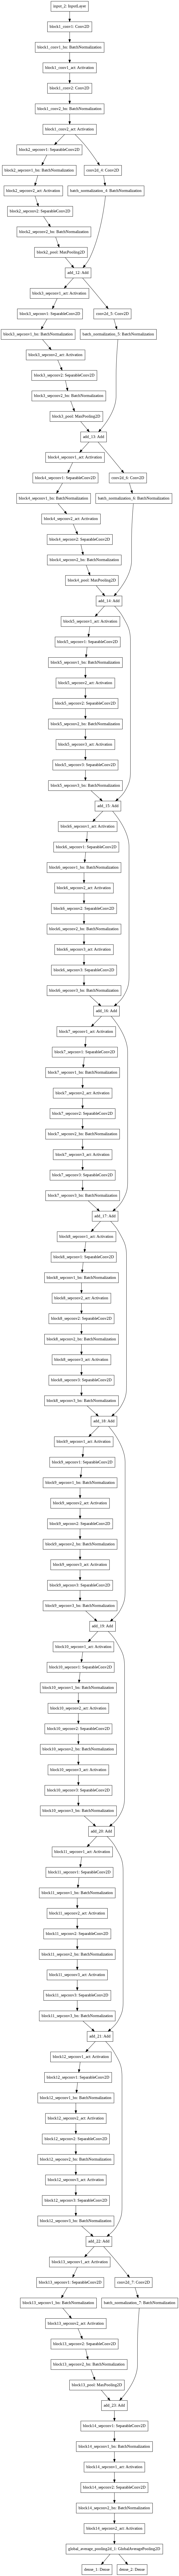

In [21]:
keras.utils.plot_model(model)

Rather than MSE it is better to use Intersection over Union(IOU) as a metric implemented by tf.keras.metrics.MeanIoU